# SagPool

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.nn import TopKPooling
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_dense_adj, dense_to_sparse, subgraph

In [3]:
dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS')
dataset = dataset.shuffle()
n = len(dataset) // 10
train_dataset = dataset[:-n]
test_dataset = dataset[-n:]
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


def plot(train_losses, train_accuracies, test_accuracies):
    # plot the loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # plot the train and test accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(test_accuracies, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def smooth(x, window_size=10):
    # smooth the curve using a convolution
    return np.convolve(x, np.ones(window_size) / window_size, mode='valid')

# original SAGPoll

In [2]:
class SAGPool(torch.nn.Module):
    def __init__(self, in_channels, ratio=0.5):
        super(SAGPool, self).__init__()
        self.ratio = ratio
        self.gcn = GCNConv(in_channels, 1)
        self.pool = TopKPooling(in_channels, ratio=self.ratio)

    def forward(self, x, edge_index, batch):
        # Compute attention scores
        score = self.gcn(x, edge_index).sigmoid()  # Ensure scores are in [0, 1]

        # Apply the attention scores to the node features
        x = x * score.view(-1, 1)  # Broadcast score across features

        # Perform pooling
        x, edge_index, _, batch, _, _ = self.pool(x, edge_index, None, batch)
        return x, edge_index, batch



class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        num_node_features = dataset.num_node_features
        self.conv1 = GCNConv(num_node_features, 128)
        self.pool1 = SAGPool(128, ratio=0.8)

        self.conv2 = GCNConv(128, 128)
        self.pool2 = SAGPool(128, ratio=0.6)

        self.conv3 = GCNConv(128, 128)
        self.lin = torch.nn.Linear(128, dataset.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x, edge_index, batch = self.pool1(x, edge_index, batch)

        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x, edge_index, batch = self.pool2(x, edge_index, batch)

        x = self.conv3(x, edge_index)
        x = torch.relu(x)

        x = global_mean_pool(x, batch)
        x = self.lin(x)

        return torch.log_softmax(x, dim=-1)


## training loop

Epoch: 001, Loss: 0.7012, Train Acc: 0.3992, Test Acc: 0.4505
Epoch: 002, Loss: 0.6914, Train Acc: 0.6008, Test Acc: 0.5495
Epoch: 003, Loss: 0.6770, Train Acc: 0.6008, Test Acc: 0.5495
Epoch: 004, Loss: 0.6675, Train Acc: 0.6008, Test Acc: 0.5495
Epoch: 005, Loss: 0.6635, Train Acc: 0.6008, Test Acc: 0.5495
Epoch: 006, Loss: 0.6602, Train Acc: 0.6008, Test Acc: 0.5495
Epoch: 007, Loss: 0.6561, Train Acc: 0.6257, Test Acc: 0.5856
Epoch: 008, Loss: 0.6567, Train Acc: 0.6427, Test Acc: 0.6126
Epoch: 009, Loss: 0.6564, Train Acc: 0.6437, Test Acc: 0.5946
Epoch: 010, Loss: 0.6525, Train Acc: 0.6387, Test Acc: 0.5946
Epoch: 011, Loss: 0.6491, Train Acc: 0.6397, Test Acc: 0.6036
Epoch: 012, Loss: 0.6439, Train Acc: 0.6427, Test Acc: 0.5856
Epoch: 013, Loss: 0.6394, Train Acc: 0.6477, Test Acc: 0.6036
Epoch: 014, Loss: 0.6385, Train Acc: 0.6457, Test Acc: 0.6036
Epoch: 015, Loss: 0.6330, Train Acc: 0.7026, Test Acc: 0.6667
Epoch: 016, Loss: 0.6275, Train Acc: 0.6986, Test Acc: 0.6396
Epoch: 0

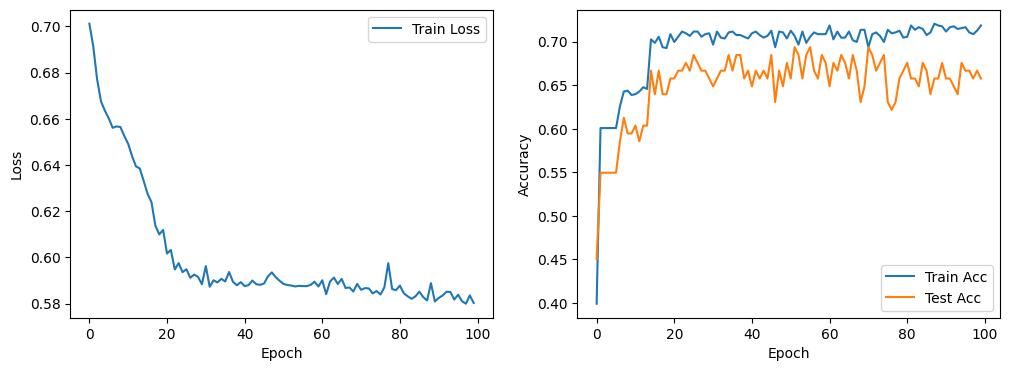

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data).max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

train_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(1, 101):
    train_loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
plot(train_losses, train_accuracies, test_accuracies)

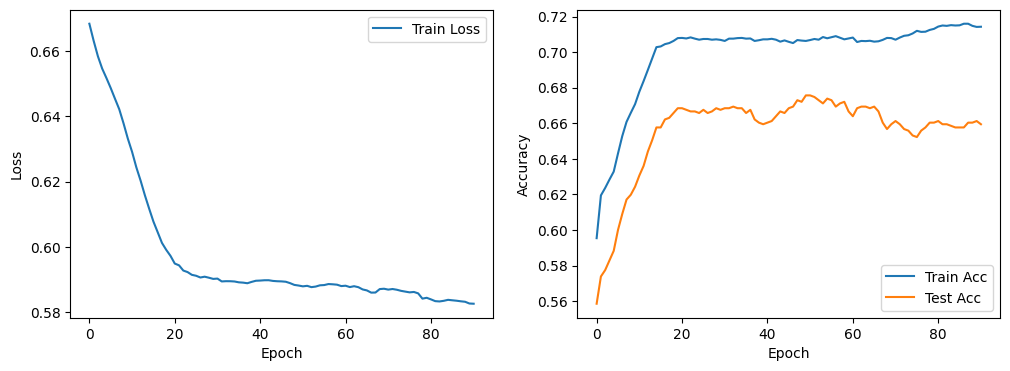

In [47]:
smoothed_train_losses = smooth(train_losses)
smoothed_train_accuracies = smooth(train_accuracies)
smoothed_test_accuracies = smooth(test_accuracies)

plot(smoothed_train_losses, smoothed_train_accuracies, smoothed_test_accuracies)


# Modified SAGPool

The task here is changing this selection process,
While selecting from top-k, we do not want to select nodes who are neighbors. So if a node is selected,
then It should eliminate its neighbors from candidate list and the select the next node who is not
neighbors of a selected node.

Use Pytorch Geometric (https://pytorch.org/docs/stable/nn.html#pooling-layers)

Apply your pooling method for one graph classification data set. Compare results with original sagpool.

In [31]:
class CustomSAGPool(torch.nn.Module):
    def __init__(self, in_channels, ratio=0.5):
        super(CustomSAGPool, self).__init__()
        self.ratio = ratio
        self.gcn = GCNConv(in_channels, 1)

    def forward(self, x, edge_index, batch):
        # Compute attention scores using a GCN layer
        scores = self.gcn(x, edge_index).sigmoid()

        # Process graphs in batch separately
        x_out = []
        edge_index_out = []
        batch_out = []
        
        for batch_id in range(batch.max() + 1):
            # Mask to process only nodes for the current batch
            batch_mask = (batch == batch_id)
            
            # Extract the subgraph for the current batch
            sub_x = x[batch_mask]
            sub_score = scores[batch_mask]
            sub_edge_index, _ = subgraph(batch_mask, edge_index, relabel_nodes=True, num_nodes=x.size(0))

            # Dense adjacency matrix for subgraph
            dense_adj = to_dense_adj(sub_edge_index, max_num_nodes=sub_x.size(0)).squeeze(0)

            # Sort nodes based on scores
            num_nodes = int(self.ratio * sub_x.size(0))
            _, idx = sub_score.view(-1).sort(descending=True)

            # Mask to keep track of remaining nodes
            mask = torch.ones(sub_x.size(0), dtype=torch.bool, device=sub_x.device)

            # List to collect selected nodes
            selected = []

            for i in idx:
                if mask[i]:
                    # Add node to selected list
                    selected.append(i)
                    # Remove the node and its neighbors from the mask
                    mask[i] = False
                    mask[dense_adj[i] > 0] = False
                    if len(selected) >= num_nodes:
                        break

            # Filter nodes based on the final selected list
            selected = torch.tensor(selected, device=sub_x.device)
            new_edge_index, _ = dense_to_sparse(dense_adj[selected][:, selected])

            # Append subgraph results to outputs
            x_out.append(sub_x[selected])
            edge_index_out.append(new_edge_index)
            batch_out.append(torch.full((selected.size(0),), batch_id, dtype=torch.long, device=sub_x.device))

        # Concatenate all subgraphs back into batched format
        x_out = torch.cat(x_out, dim=0)
        edge_index_out = torch.cat(edge_index_out, dim=1)
        batch_out = torch.cat(batch_out, dim=0)

        return x_out, edge_index_out, batch_out



class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        num_node_features = dataset.num_node_features
        num_classes = dataset.num_classes
        self.conv1 = GCNConv(num_node_features, 128)
        self.pool1 = CustomSAGPool(128, ratio=0.8)

        self.conv2 = GCNConv(128, 128)
        self.pool2 = CustomSAGPool(128, ratio=0.6)

        self.conv3 = GCNConv(128, 128)
        self.lin = torch.nn.Linear(128, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x, edge_index, batch = self.pool1(x, edge_index, batch)

        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x, edge_index, batch = self.pool2(x, edge_index, batch)

        x = self.conv3(x, edge_index)
        x = torch.relu(x)

        x = global_mean_pool(x, batch)
        x = self.lin(x)

        return torch.log_softmax(x, dim=-1)


## training loop

Epoch: 001, Loss: 0.6688, Train Acc: 0.6327, Test Acc: 0.6216
Epoch: 002, Loss: 0.6493, Train Acc: 0.6657, Test Acc: 0.6757
Epoch: 003, Loss: 0.6414, Train Acc: 0.6627, Test Acc: 0.6667
Epoch: 004, Loss: 0.6394, Train Acc: 0.6647, Test Acc: 0.6757
Epoch: 005, Loss: 0.6364, Train Acc: 0.6687, Test Acc: 0.6667
Epoch: 006, Loss: 0.6316, Train Acc: 0.6677, Test Acc: 0.6577
Epoch: 007, Loss: 0.6289, Train Acc: 0.6597, Test Acc: 0.6667
Epoch: 008, Loss: 0.6240, Train Acc: 0.6637, Test Acc: 0.6667
Epoch: 009, Loss: 0.6202, Train Acc: 0.6667, Test Acc: 0.7027
Epoch: 010, Loss: 0.6194, Train Acc: 0.6657, Test Acc: 0.6847
Epoch: 011, Loss: 0.6177, Train Acc: 0.7026, Test Acc: 0.6937
Epoch: 012, Loss: 0.6158, Train Acc: 0.7116, Test Acc: 0.7207
Epoch: 013, Loss: 0.6147, Train Acc: 0.7096, Test Acc: 0.7297
Epoch: 014, Loss: 0.6150, Train Acc: 0.7016, Test Acc: 0.7027
Epoch: 015, Loss: 0.6151, Train Acc: 0.7086, Test Acc: 0.7207
Epoch: 016, Loss: 0.6132, Train Acc: 0.7136, Test Acc: 0.7207
Epoch: 0

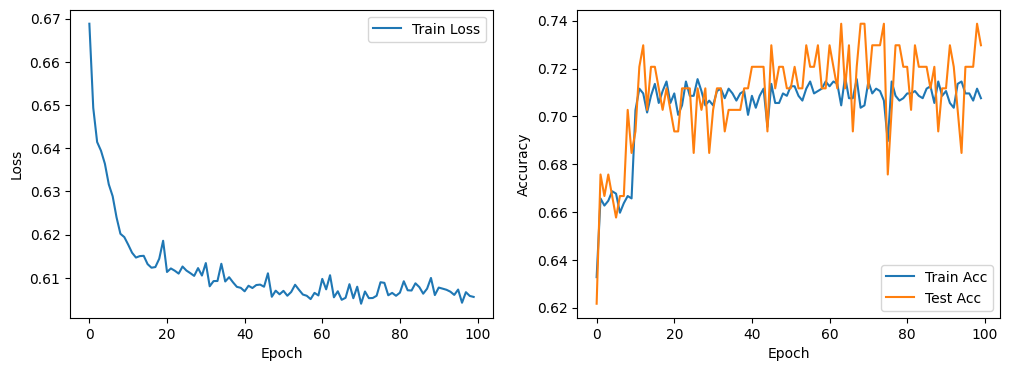

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data).max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

train_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(1, 101):
    train_loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
plot(train_losses, train_accuracies, test_accuracies)

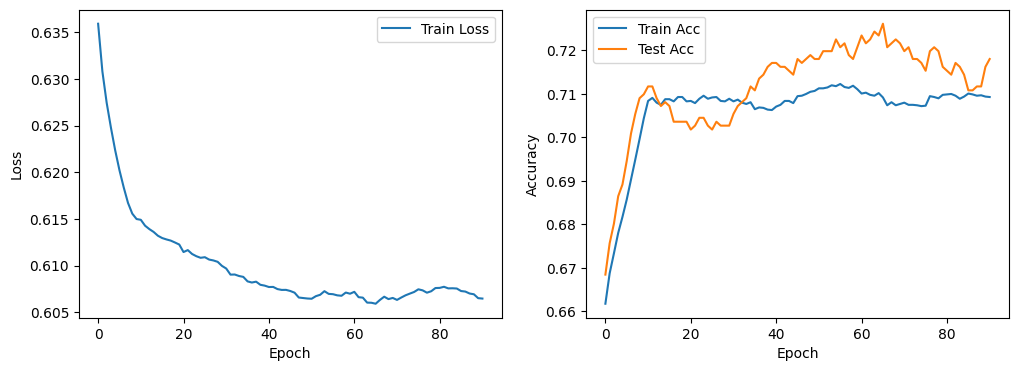

In [40]:
smoothed_train_losses = smooth(train_losses)
smoothed_train_accuracies = smooth(train_accuracies)
smoothed_test_accuracies = smooth(test_accuracies)

plot(smoothed_train_losses, smoothed_train_accuracies, smoothed_test_accuracies)

# Conclusion
- Unlike the original SAGPool, this custom implementation excludes a node's neighbors from being selected once the node is chosen. This aims to ensure a more diverse representation by avoiding closely connected nodes that might share similar features or roles within the graph.

- The original SAGPool treats the whole batch as one large graph, which could potentially lead to information leakage across graph boundaries. This implementation processes each graph individually, respecting the boundaries and independent nature of each graph in the batch.

- This approach is slightly more complex due to the need to handle subgraphs individually and manage additional state (the mask) for neighbor exclusion.

- We can see from the plots that the modified version is underfitting because the train loss is higher than the test loss. This is because the model does not consider the neighboor nodes. And probably we should train this longer so that the model would converge.